<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2010%20-%20Unsupervised%20Representation%20Learning/Lecture%2010%20-%20Representation_Learning_and_Semi_Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representation Learning and Semi-Supervised Learning

> This notebook was created by Prof. Andre Hochuli to support the lecture on Unsupervised Representation Learning and Autoencoders.

> It is freely available for use, modification, and adaptation for educational or research purposes, according to individual needs.





Representation learning aims to automatically discover meaningful features or representations from raw data, enabling models to capture intrinsic structures without manual feature engineering. By learning latent embeddings that preserve relevant information, such approaches enhance generalization and downstream performance in tasks such as classification, clustering, or anomaly detection.

Semi-supervised learning extends this paradigm by leveraging both labeled and unlabeled data during training. Since labeled samples are often scarce and costly to obtain, semi-supervised methods exploit the abundance of unlabeled data to improve model robustness and reduce overfitting. Techniques combining representation learning and semi-supervised frameworks, such as autoencoders or consistency-based models, are particularly effective for domains with limited annotations, including medical imaging and remote sensing.

Typical architectures for representation learning and semi-supervised learning include:

Autoencoders (AEs) – Learn compact latent representations by reconstructing inputs. Variants include Denoising Autoencoders, Variational Autoencoders (VAEs), and Sparse Autoencoders.

Contrastive Models – Learn discriminative embeddings by maximizing similarity between positive pairs and minimizing it for negatives. Examples: SimCLR, MoCo, and BYOL.

Generative Models – Capture data distribution to generate new samples, such as Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs).

Self-Supervised Architectures – Use pretext tasks (e.g., predicting masked pixels, rotations, or missing patches). Examples: Masked Autoencoders (MAE), SimSiam, and Barlow Twins.

Semi-Supervised CNNs and Transformers – Combine supervised loss on labeled data with unsupervised consistency or entropy minimization on unlabeled data. Examples: Mean Teacher, FixMatch, and MixMatch.

Graph Neural Networks (GNNs) – Learn representations over structured data using relational information, often under semi-supervised settings (e.g., Graph Convolutional Networks).

Each architecture differs in objective and inductive bias, but all aim to extract informative, transferable latent spaces from limited supervision.

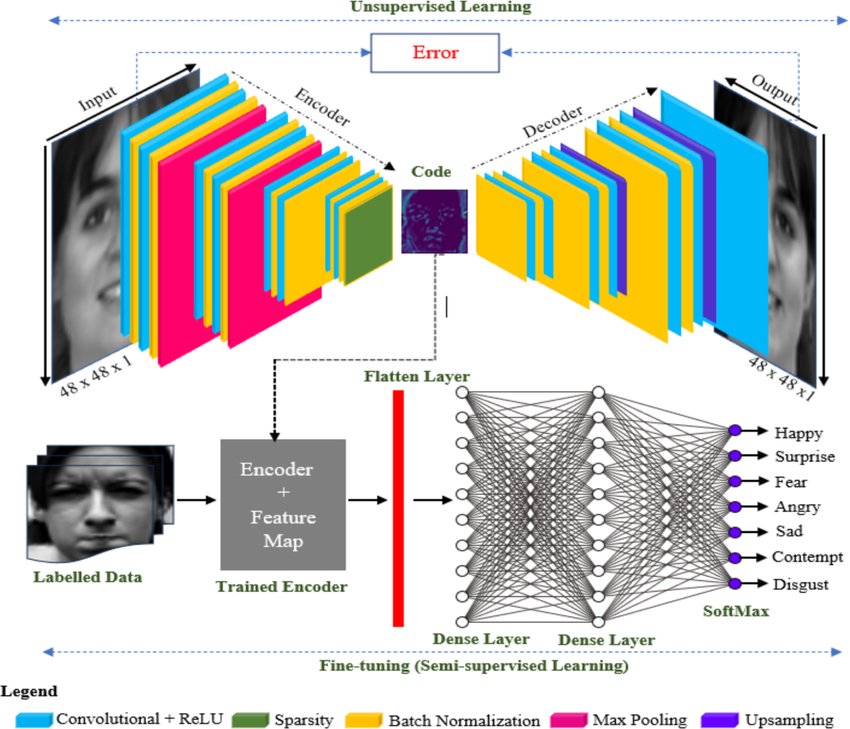

In this notebook, we will first train an unsupervised Autoencoder to learn latent representations from a natural image dataset (Kyoto). The Autoencoder aims to capture general visual features such as color composition, texture, and spatial structure without using labels.

After this unsupervised pretraining phase, we will transfer the learned encoder and fine-tune it on a Simpsons dataset, focusing on a binary classification task to determine whether the input image corresponds to Bart or Homer. This two-stage approach: i) unsupervised representation learning followed by a ii) shallow supervised classifier, illustrates how feature transfer can improve performance when labeled data is limited or comes from a different domain.

#Notebook Initialization

In [ ]:
!pip install torchinfo

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
import cudf
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import train_test_split

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchsummary
import torchinfo
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader,Subset
from torchvision.models import vgg16, VGG16_Weights
import numpy as np
import math, time, os
import copy, random
import pickle

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## Auxiliary Functions

In [ ]:
class MosaicSaver:
    def __init__(self, save_dir, base_name, normalize=True):
        """
        save_dir: directory to save mosaics
        base_name: base filename prefix
        normalize: whether to scale images to [0,255]
        """
        self.save_dir = save_dir
        self.base_name = base_name
        self.normalize = normalize
        os.makedirs(save_dir, exist_ok=True)

    def save(self, val_images, reconstructed_images, pattern_str):
        """
        val_images: torch.Tensor of shape [batch, C, H, W]
        reconstructed_images: torch.Tensor of shape [batch, C, H, W]
        epoch: current epoch number
        """
        val_np = val_images.cpu().detach().numpy()
        rec_np = reconstructed_images.cpu().detach().numpy()

        mosaic = None
        for im, rec in zip(val_np, rec_np):
            img = np.concatenate([im.transpose(1,2,0), rec.transpose(1,2,0)], axis=1)
            if mosaic is None:
                mosaic = img
            else:
                mosaic = np.concatenate([mosaic, img], axis=0)

        if self.normalize:
            mosaic = np.clip(mosaic, 0, 1) * 255
        mosaic = mosaic.astype(np.uint8)
        mosaic_img = Image.fromarray(mosaic)
        mosaic_img.save(f"{self.save_dir}/{self.base_name}-outputs/{pattern_str}-mosaic.png")
        del mosaic, mosaic_img

class TrainingHistory:
    def __init__(self, save_dir, name):
        """
        save_dir: directory to save history files
        name: base name for files
        """
        self.save_dir = save_dir
        self.name = name
        self.history = {'loss': [], 'val_loss': []}
        self.best_epoch = 0

    def append(self, train_loss, val_loss, epoch):
        self.history['loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        # Update best epoch
        if val_loss == min(self.history['val_loss']):
            self.best_epoch = epoch

    def save(self):
        # Save history object
        with open(f"{self.save_dir}/{self.name}_history.pkl", 'wb') as f:
            pickle.dump(self.history, f)

    def plot(self):
        epochs = range(1, len(self.history['loss']) + 1)
        plt.figure(figsize=(8, 6))
        plt.plot(epochs, self.history['loss'], label='Training Loss')
        plt.plot(epochs, self.history['val_loss'], label='Validation Loss')
        plt.axvline(x=self.best_epoch, color='blue', linestyle='--', linewidth=2,
                    label=f'Best Epoch ({self.best_epoch})')
        plt.title('Training and Validation Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(f'{self.save_dir}/{self.name}_history.png')
        plt.close()

In [ ]:
def load_file_list(txt_file):
    file_list = []

    # Read file paths
    with open(txt_file, "r") as f:
        for line in f.readlines():
            array = line.strip()
            file_list.append(array)

    file_list = np.array(file_list)

    return file_list

def load_file_list_labeled(txt_file):
    file_list = []
    labels = []

    # Read file paths
    with open(txt_file, "r") as f:
        for line in f.readlines():
            array = line.strip()
            file_list.append(array)

            if 'bart' in array:
                label = 0
            elif 'homer' in array:
                label = 1
            else:
                label = int(array.split('/')[1])-1


            labels.append(label)

    file_list = np.array(file_list)
    labels = np.array(labels)


    # Shuffle randomly
    combined = list(zip(file_list, labels))
    random.shuffle(combined)
    file_list, labels = zip(*combined)
    file_list = np.array(file_list)
    labels = np.array(labels)

    print(np.unique(labels, return_counts=True))
    return file_list, labels

# Define a custom dataset
class FileListDataset(Dataset):
    def __init__(self, file_list, labels=None, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.file_list[idx]

        image = Image.open(img_path).convert("RGB")  # Convert to RGB

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Load the label if provided
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image

In [ ]:
!wget www.ppgia.pucpr.br/~aghochuli/kyoto.zip

In [ ]:
!unzip kyoto.zip
!find kyoto -name "*.jpg" > filelist.txt

In [ ]:
all = load_file_list("filelist.txt")

X_train = all[:44]
X_val = all[44:53]
X_test = all[53:]
print(all.shape, X_train.shape, X_val.shape, X_test.shape)

#Unsupervised Step

In this stage, the Skip Autoencoder is trained on the Kyoto natural image dataset under an unsupervised objective. The model reconstructs its input images, enabling the encoder to learn compact and semantically meaningful representations that capture both global structure and fine texture information. These representations are later transferred and fine-tuned for the Simpsons classification task, where the goal is to distinguish between Bart and Homer images.

Training Setup

* Input: Unlabeled natural images from the Kyoto dataset

* Loss Function: Hybrid reconstruction loss combining Mean Squared Error (MSE) and Perceptual Loss, ensuring both pixel-level accuracy and perceptual fidelity

* Goal: Minimize reconstruction error to learn robust and transferable latent features that generalize across domains





## The Skip Autoenconder

The Skip Autoencoder is a variant of the traditional autoencoder that introduces skip connections between corresponding encoder and decoder layers. These connections allow the decoder to directly access spatial details from earlier encoder layers, improving reconstruction quality and preserving fine-grained visual features.

This architecture is especially useful for natural image datasets, where texture and local patterns are important for meaningful latent representations. By maintaining multi-scale information flow, the skip autoencoder facilitates better generalization when transferring learned features to a downstream classification task.

Architecture Overview

Encoder: progressively compresses the input image using convolution and pooling layers to capture hierarchical features.

Latent Space: represents a compact encoding of the input, capturing its essential structure.

Decoder: reconstructs the image from the latent representation, guided by skip connections that inject encoder features at each resolution level.

In [ ]:
class SkipAutoEncoder(nn.Module):
    def __init__(self, input_channels=3, input_size=(128, 128),
                 max_layers=4, filters=[8, 16, 32, 64, 128], latent_dim=2048):
        super(SkipAutoEncoder, self).__init__()

        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        in_channels = input_channels
        h, w = input_size
        self.skip_channels = []

        # ----- Encoder -----
        for i in range(max_layers):
            out_channels = filters[i]
            kernel_size = 3
            padding = kernel_size // 2
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            self.encoder_blocks.append(block)
            self.skip_channels.append(out_channels)
            in_channels = out_channels

        # ----- Bottleneck -----
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * 2, 3, padding=1),
            nn.BatchNorm2d(in_channels * 2),
            nn.ReLU(inplace=True)
        )
        bottleneck_channels = in_channels * 2

        # ----- Latent projection -----
        reduced_h = max(1, h // (2 ** max_layers))
        reduced_w = max(1, w // (2 ** max_layers))
        self.flatten = nn.Flatten()
        self.fc_latent = nn.Linear(bottleneck_channels * reduced_h * reduced_w, latent_dim)

        # ----- Decoder -----
        prev_channels = bottleneck_channels
        for i in range(max_layers):
            skip_ch = self.skip_channels[-(i + 1)]
            out_channels = skip_ch

            block = nn.Sequential(
                nn.ConvTranspose2d(prev_channels, out_channels,
                                   kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            self.decoder_blocks.append(block)

            # after concat (post forward), channels will double
            prev_channels = out_channels + skip_ch

        # ----- Final reconstruction -----
        self.final_conv = nn.Sequential(
            nn.Conv2d(filters[0] * 2, input_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        skips = []
        out = x

        # ----- Encoder -----
        for enc in self.encoder_blocks:
            out = enc(out)
            skips.append(out)
            out = self.pool(out)

        # ----- Bottleneck -----
        out = self.bottleneck(out)
        latent = self.fc_latent(self.flatten(out))

        # ----- Decoder -----
        for i, dec in enumerate(self.decoder_blocks):
            out = dec(out)
            skip = skips[-(i + 1)]
            # Align spatial dimensions before concatenation
            if out.size()[2:] != skip.size()[2:]:
                out = F.interpolate(out, size=skip.size()[2:], mode='bilinear', align_corners=False)
            out = torch.cat([out, skip], dim=1)

        # ----- Output -----
        out = self.final_conv(out)
        return skips[-1], latent, out

In [ ]:
im_channels = 3
epochs = 300
patience_epochs = 5
weight_decay =  10**-4
learning_rate = 10**-3
img_size = 96
batch_size = 64
seed = 42

autoencoder_name = 'aec'

filters = [8,16,24,32,40]
fixed_latent_dim = 1024
max_layers = 5

flush_epochs = 1 #save models, validation_images(mosaic), plot_history

data_dir = "aec-outputs"

os.makedirs(data_dir,exist_ok=True)
os.makedirs(f'{data_dir}/{autoencoder_name}-outputs',exist_ok=True)

In [ ]:
model = SkipAutoEncoder(input_channels=im_channels, input_size=(img_size, img_size),
                                    max_layers=max_layers, filters=filters,latent_dim=fixed_latent_dim)

torchinfo.summary(model, input_size=(1, im_channels, img_size, img_size))  # batch size 32

##Dataset Initialization (DataLoader)

To enhance generalization and improve robustness to visual variability, Gaussian noise and data augmentation are applied during the unsupervised training phase. Adding controlled noise prevents the autoencoder from simply memorizing inputs, forcing it to learn invariant, noise-tolerant representations. Similarly, geometric and photometric transformations expand the effective dataset diversity, helping the encoder capture domain-independent visual features.

Data Augmentation Strategy

* Gaussian Noise: Introduced at the input layer to encourage denoising capability.

* Transformations: Random flips, rotations, Colors, Rotatations

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

transform = transforms.Compose([
    transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    AddGaussianNoise(mean=0.05, std=0.02),  # Add Gaussian noise
])

transform_val = transforms.Compose([
    transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
   ])


train_dataset = FileListDataset(X_train, labels=None, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, persistent_workers=False, num_workers=1)

val_dataset = FileListDataset(X_val, labels=None, transform=transform_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, persistent_workers=False, num_workers=1)
images = next(iter(val_loader))  # Get the first batch

## Training Loop

In [ ]:
#vgg to compute perceptual loss
vgg = vgg16(weights=VGG16_Weights.DEFAULT).features[:5]  # Use early layers
vgg.eval()  # Set VGG to evaluation mode

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)#, amsgrad=True)

mse_loss_weight = 0.5
perceptual_loss_weight = 1-mse_loss_weight

# Move the model to the GPU
model.to(device)
vgg.to(device)

dataset_size = len(train_dataset)
batch_size = train_loader.batch_size
num_batches = math.ceil(dataset_size / batch_size)
val_images = torch.from_numpy(np.array(images[:10])).float().to(device)

print(f"Number of iterations per epoch: {num_batches}")

model.train()

best_loss=float('inf')

patience = patience_epochs

with open(f'{data_dir}/{autoencoder_name}.params','w') as f:
    for key, value in list(locals().items()):
        if key != "f":  # Avoid including the file handle itself
            f.write(f"{key} = {value}\n")
            if not 'list' and not 'label' in key:
                print(f"{key} = {value}\n")
f.close()

history = {'loss': [], 'val_loss': []}
best_epoch = 0
best_model = None
history_logger = TrainingHistory(save_dir=data_dir, name=autoencoder_name)
mosaic_saver = MosaicSaver(save_dir=data_dir, base_name=autoencoder_name)

start = time.time()


for epoch in range(epochs):
    torch.cuda.empty_cache()
    epoch += 1
    epoch_loss = 0.0
    iter_count = 0
    t1_epoch = time.time()
    for images in train_loader:

        images = torch.from_numpy(np.array(images)).float().to(device)
        t1 = time.time()


        out = model(images)
        with torch.no_grad():
            features_real = vgg(images)

        features_reconstructed = vgg(out[-1])
        # Combine losses
        loss_reconstruction = mse_loss(out[-1], images)
        loss_perceptual = mse_loss(features_reconstructed, features_real)
        loss = (loss_reconstruction * mse_loss_weight) + (perceptual_loss_weight * loss_perceptual)  # Weight perceptual loss

        epoch_loss += loss.item()

        elapsed = time.time() - t1

        print(f'Iteration {iter_count:04d} / {num_batches:04d} ({elapsed:.3f} secs) Loss {loss:.04f}', end='\r', flush=True)
        iter_count += 1

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Iteration {iter_count:04d} / {num_batches:04d} Loss {loss:.06f}', end=' ' , flush=True)

    train_loss = epoch_loss / len(train_loader)
    #history['loss'].append(train_loss)

    t_actual = time.time()
    elapsed = t_actual - t1_epoch

    val_loss = 0.0
    for images in val_loader:
        images = torch.from_numpy(np.array(images)).float().to(device)

        out = model(images)
        with torch.no_grad():
            features_real = vgg(images)

        features_reconstructed = vgg(out[-1])
        # Combine losses
        loss_reconstruction = mse_loss(out[-1], images)
        loss_perceptual = mse_loss(features_reconstructed, features_real)
        loss = (loss_reconstruction * mse_loss_weight) + (perceptual_loss_weight * loss_perceptual)  # Weight perceptual loss

        val_loss += loss.item()



    history_logger.append(train_loss, val_loss, epoch)

    elapsed_training = t_actual - start

    hours = int(elapsed_training // 3600)
    minutes = int((elapsed_training % 3600) // 60)
    seconds = elapsed_training % 60


    print(f"Epoch [{epoch + 1}/{epochs}] ({elapsed:.3f} secs), Loss: {train_loss:.6f}, Val_Loss: {val_loss:.6f} - Patience {patience}", flush=True)


    patience -= 1

    if val_loss < best_loss:
        best_epoch = epoch
        #logger.print(f"####### The val_loss improve from {val_loss:.6f} to {best_loss:.6f} #######")
        print(f"####### The val_loss improve from {best_loss:.6f} to {val_loss:.6f} #######")
        #print(f"####### The val_loss improve from {best_loss:.6f} to {val_loss:.6f} #######", file=f)
        best_loss = val_loss
        best_model = copy.deepcopy(model)
        patience = patience_epochs

    #flush best model, mosaic_img, history_plot
    if epoch % flush_epochs == 0 or epoch == 1:
        torch.save(best_model, f"{data_dir}/{autoencoder_name}_best.pth")

        #logger.print(f"####### Saving model for epoch {best_epoch}. The val_loss improve from {val_loss:.6f} to {best_loss:.6f} #######", )
        #logger.flush()
        print(f"Saving model for epoch {best_epoch}. The val_loss improve from {best_loss:.6f} to {val_loss:.4f}", flush=True )
        #print(f"Saving model for epoch {best_epoch}. The val_loss improve from {best_loss:.6f} to {val_loss:.6f}", flush=True, file=f)

        out = model(val_images) #mu, logvar, reconstructed
        reconstructed = out[-1] # == reconstructed

        print(val_images.shape, reconstructed.shape)
        mosaic_saver.save(val_images, reconstructed, f"{epoch:04d}")

        history_logger.save()
        history_logger.plot()

    if patience <= 0:
        print(f"Patience has ended the training. The model did not improve after {patience_epochs} epochs", flush=True)
        break


torch.cuda.empty_cache()

## Saving Models Weights

In [ ]:
torch.cuda.empty_cache()

# Save the trained model
torch.save(best_model, f"{data_dir}/{autoencoder_name}_best.pth")
torch.save(model, f"{data_dir}/{autoencoder_name}_last.pth")

history_logger.save()
history_logger.plot()

out = model(val_images)
reconstructed = out[-1]
mosaic_saver.save(val_images, reconstructed, f"{epoch:04d}")

## Reconstruct Test Dataset (Unseen Images)

In [ ]:
test_dataset = FileListDataset(X_test, labels=None, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, persistent_workers=False, num_workers=1)
images = next(iter(test_loader))  # Get the first batch

# Get the first 5 images and their corresponding labels
test_images = torch.from_numpy(np.array(images[:10])).float().to(device)
out = best_model(test_images)
reconstructed = out[-1]
mosaic_saver.save(test_images, reconstructed, f"best-{best_epoch:04d}")


with torch.no_grad():
    features_real = vgg(test_images)

features_reconstructed = vgg(out[-1])
# Combine losses
loss_reconstruction = mse_loss(out[-1], test_images)
loss_perceptual = mse_loss(features_reconstructed, features_real)
loss = (loss_reconstruction * mse_loss_weight) + (perceptual_loss_weight * loss_perceptual)  # Weight perceptual loss
print(f"Best Model - Test Loss {loss.item():.6f}")

#Supervised Step — Fine-Tuning for Classification

In this phase, the pretrained encoder from the Skip Autoencoder is reused as a feature extractor for a supervised classification task. The model is fine-tuned on the Simpsons dataset, restricted to two classes — Bart and Homer. This setup demonstrates how representations learned from unlabeled natural images (Kyoto dataset) can be effectively transferred to a new domain with limited labeled data.

Training Setup

* Input: Labeled images from the Simpsons dataset (Bart, Homer)

* Base: Encoder pretrained in the unsupervised stage (weights reused)

* Classifier: Shallow fully connected (FC) network trained on top of the frozen or partially fine-tuned encoder

* Loss: Categorical Cross-Entropy

* Goal: Classify characters based on latent representations learned from natural image

In [ ]:
!wget www.ppgia.pucpr.br/~aghochuli/Simpsons.zip

In [ ]:
!unzip Simpsons.zip
!find Simpsons/Treino \( -iname "*bart*" -o -iname "*homer*" \) > simpsons_treino.txt

!find Simpsons/Teste \( -iname "*bart*" -o -iname "*homer*" \) > simpsons_test.txt

In [ ]:
X_train, y_train = load_file_list_labeled("simpsons_treino.txt")
X_test, y_test = load_file_list_labeled("simpsons_test.txt")
print(X_train.shape)
print(X_test.shape)


In [ ]:
savedir = "classifier-outputs"
data_dir = "classifier-outputs"
img_size = 96
model_weights = 'aec-outputs/aec_best.pth'
print(f"Weights: {model_weights} | Train: {len(X_train)} | Val: {len(X_val)} | ImgSize: {img_size}")

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])


autoencoder = torch.load(model_weights, weights_only=False, map_location=device)
autoencoder = autoencoder.to(device)
autoencoder.eval()


data_dir = savedir + '/svm/'
os.makedirs(savedir + '/svm/', exist_ok=True)


# ==========================
# Data Loaders
# ==========================
batch_size = 64
print(y_train.shape)
train_dataset = FileListDataset(X_train, labels=y_train, transform=transform)
test_dataset = FileListDataset(X_test, labels=y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



## Feature Extraction - Latent Representation

In [ ]:
# ==========================
# Feature Extraction
# ==========================
def extract_features(dataloader):
    all_feats = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            _, latent, _ = autoencoder(images)
            feats = latent.view(latent.size(0), -1).cpu().numpy()
            all_feats.append(feats)
            all_labels.append(labels.numpy())
    return np.concatenate(all_feats), np.concatenate(all_labels)

print("Extracting train features...")
X_train_latent, y_train_latent = extract_features(train_loader)
print("Latent Train: ", X_train_latent.shape,y_train_latent.shape)
print("Extracting val features...")
X_test_latent, y_test_latent = extract_features(test_loader)
print("Latent Val: ", X_test_latent.shape,y_test_latent.shape)

# ==========================
# Convert to cuDF for RAPIDS
# ==========================
X_train_gpu = cudf.DataFrame(X_train_latent)
y_train_gpu = cudf.Series(y_train_latent)
X_test_gpu = cudf.DataFrame(X_test_latent)
y_test_gpu = cudf.Series(y_test_latent)


## Supervised Training

In [ ]:

# ========================================================
# Train Supervised Classifier with Latent Representations
# ========================================================

model = RandomForestClassifier(
    n_estimators=300,
    #max_depth=8,
    min_samples_split=5,
    #max_features='sqrt',
    bootstrap=True,
    random_state=42
)

t0 = time.time()
model.fit(X_train_gpu, y_train_gpu)
elapsed = time.time() - t0
print(f"SVM training finished in {elapsed:.2f}s")

# ==========================
# Evaluation
# ==========================
train_acc = model.score(X_train_gpu, y_train_gpu)
test_acc = model.score(X_test_gpu, y_test_gpu)
print(f"Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

# ==========================
# Predictions
# ==========================
y_train_pred = model.predict(X_train_gpu).get() if hasattr(model.predict(X_train_gpu), "get") else model.predict(X_test_gpu)
y_test_pred   = model.predict(X_test_gpu).get() if hasattr(model.predict(X_test_gpu), "get") else model.predict(X_test_gpu)

y_train_true = y_train_gpu.get() if hasattr(y_train_gpu, "get") else y_train_gpu
y_test_true   = y_test_gpu.get() if hasattr(y_test_gpu, "get") else y_test_gpu

# ==========================
# Confusion Matrix
# ==========================
def to_numpy_safe(x):
    if hasattr(x, "get"):           # CuPy array
        return x.get()
    elif hasattr(x, "to_numpy"):    # cuDF Series/DataFrame
        return x.to_numpy()
    else:
        return np.asarray(x)        # already NumPy or list


y_train_pred = to_numpy_safe(model.predict(X_train_gpu))
y_test_pred   = to_numpy_safe(model.predict(X_test_gpu))
y_train_true = to_numpy_safe(y_train_gpu)
y_test_true   = to_numpy_safe(y_test_gpu)


cm_train = confusion_matrix(y_train_true, y_train_pred)
cm_test   = confusion_matrix(y_test_true, y_test_pred)

with open(f"{data_dir}/cm_train.txt", "w") as f:
    f.write("Train Confusion Matrix:\n")
    for row in cm_train:
        f.write(" ".join(f"{x:5d}" for x in row) + "\n")

with open(f"{data_dir}/cm_test.txt", "w") as f:
    f.write("Test Confusion Matrix:\n")
    for row in cm_test:
        f.write(" ".join(f"{x:5d}" for x in row) + "\n")

# Save numeric results
np.save(f"{data_dir}/cm_train.npy", cm_train)
np.save(f"{data_dir}/cm_test.npy", cm_test)

# Optional: Plot and save heatmaps
def plot_and_save_cm(cm, filename, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

plot_and_save_cm(cm_train, f"{data_dir}/cm_train.png", "Confusion Matrix - Train")
plot_and_save_cm(cm_test, f"{data_dir}/cm_test.png", "Confusion Matrix - Validation")

# ==========================
# Classification Report
# ==========================
report_train = classification_report(y_train_true, y_train_pred, digits=4)
report_test   = classification_report(y_test_true, y_test_pred, digits=4)

with open(f"{data_dir}/report_train.txt", "w") as f:
    f.write(report_train)

with open(f"{data_dir}/report_test.txt", "w") as f:
    f.write(report_test)

print("Classification reports saved.")
print(report_train)
print(report_test)

#Fully Supervised

In the fully supervised approach, the model is trained end-to-end using only labeled images from the Simpsons dataset (Bart and Homer). This setup provides a direct way to assess the trade-off between unsupervised and supervised learning.

Training Setup

* Input: Labeled Simpsons images (Bart, Homer)

* Loss Function: Categorical Cross-Entropy

* Goal: Learn discriminative features directly from labeled data

In [ ]:
from torch.utils.data import random_split, DataLoader


val_ratio = 0.2
n_total = len(train_dataset)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

train_subset, val_subset = random_split(train_dataset, [n_train, n_val])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

In [ ]:
class CNN5(nn.Module):
    def __init__(self, input_channels=3, num_classes=2):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)


        self.fc = nn.Linear(512 * 3 * 3, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
import copy
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN5(input_channels=3, num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 50

best_val_loss = float('inf')
best_model_wts = None

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)


    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, "best_cnn5.pth")
        print(f"### Saved best model (val_loss={val_loss:.4f})###")


In [ ]:
model.load_state_dict(torch.load("best_cnn5.pth"))

model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total:.4f}")

Although both models (unsupervised and supervised) achieve comparable accuracy, the unsupervised representation, when coupled with a shallow classifier, reaches similar performance at a significantly lower computational cost.

#Final Remarks

It is important to emphasize that the autoencoder is trained only once, and in a different context, specifically, on the Kyoto natural image dataset. This dataset is entirely independent of the target domain (Simpsons), yet the encoder’s learned representations generalize effectively when transferred.

This separation between pretraining (unsupervised, Kyoto) and fine-tuning (supervised, Simpsons) highlights the core principle of representation reuse: knowledge extracted from large unlabeled data can be adapted to new tasks with minimal additional supervision. Consequently, the overall computational cost is reduced, since the autoencoder’s training can serve multiple downstream tasks without retraining from scratch.